In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch_lr_finder import LRFinder
import data,utils,model,engine
from torchsummary import summary

In [2]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 2,
    'pin_memory': True,
}  

In [4]:
transform = data.transformed_data()
dataset = data.get_data(transform)
load = data.get_dataloader(dataset, dataloader_args)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

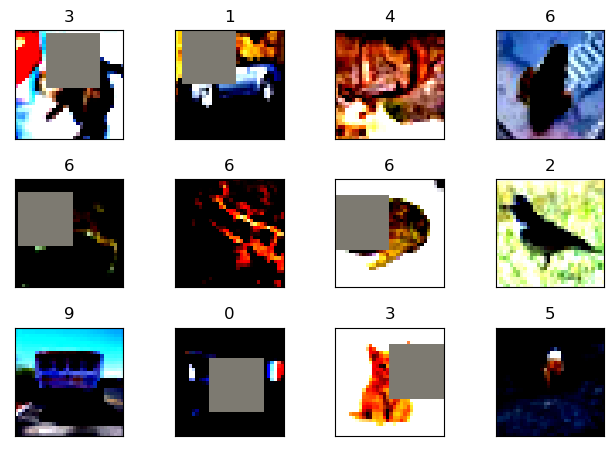

In [5]:
utils.plot_batch_samples(load['train'])

In [25]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()
model = model.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 

In [26]:
params_optimizer = {
    'lr': 1E-3, # 1E-7 -> 1E-3
}
params_lr_finder = {
    'end_lr': 1, # 10 -> 1
    'num_iter': 200, # 10 -> 200
    'step_mode': 'exp',
}

In [32]:
optimizer = optim.Adam(model.parameters(), **params_optimizer)

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.68E-03


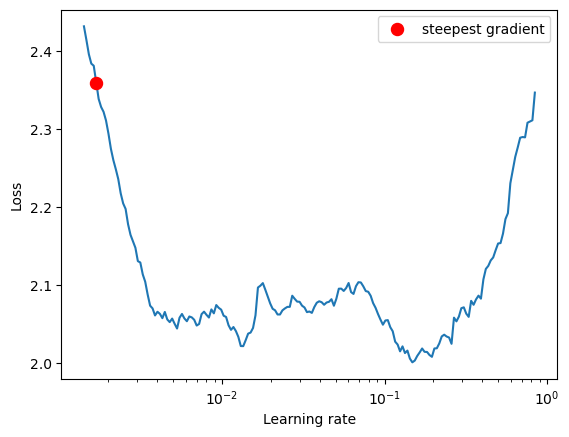

In [33]:
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device='cpu')
lr_finder.range_test(load['train'], **params_lr_finder)
lr_finder.plot() # Inspect the loss-learning rate graph
lr_finder.reset() # Reset the model and optimizer to their initial states

In [34]:
params_trainer = {
    'num_epochs': 20,
}
params_scheduler = {
    'max_lr': 1.68E-03, # From lr_finder
    'epochs': params_trainer['num_epochs'],
    'steps_per_epoch': len(load['train']), # 1 batch per step
    'pct_start': 0.2, # 20 % warm-up phase
    'anneal_strategy': 'linear', # Linear cool-down phase
    'three_phase': False, # No annihilation phase
    'div_factor': 100, # Initial LR: start from 1 % of max_lr
}

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    load['train'],
    load['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02272, Accuracy = 47.05%, Epoch = 1
Test : Loss = 0.01689, Accuracy = 61.98%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01600, Accuracy = 63.95%, Epoch = 2
Test : Loss = 0.01279, Accuracy = 70.82%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01315, Accuracy = 70.46%, Epoch = 3
Test : Loss = 0.01248, Accuracy = 72.25%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.01158, Accuracy = 74.02%, Epoch = 4
Test : Loss = 0.00961, Accuracy = 79.12%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00995, Accuracy = 77.59%, Epoch = 5
Test : Loss = 0.01001, Accuracy = 78.06%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.00860, Accuracy = 80.83%, Epoch = 6
Test : Loss = 0.00934, Accuracy = 79.96%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00736, Accuracy = 83.47%, Epoch = 7
Test : Loss = 0.00782, Accuracy = 83.34%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.00631, Accuracy = 85.90%, Epoch = 8
Test : Loss = 0.00781, Accuracy = 83.96%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00531, Accuracy = 88.20%, Epoch = 9
Test : Loss = 0.00722, Accuracy = 85.43%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00446, Accuracy = 90.08%, Epoch = 10
Test : Loss = 0.00771, Accuracy = 85.60%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00360, Accuracy = 91.77%, Epoch = 11
Test : Loss = 0.00750, Accuracy = 86.34%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00298, Accuracy = 93.28%, Epoch = 12
Test : Loss = 0.00730, Accuracy = 86.48%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00241, Accuracy = 94.62%, Epoch = 13
Test : Loss = 0.00803, Accuracy = 86.55%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00196, Accuracy = 95.67%, Epoch = 14
Test : Loss = 0.00773, Accuracy = 87.37%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.00162, Accuracy = 96.33%, Epoch = 15
Test : Loss = 0.00758, Accuracy = 87.86%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00134, Accuracy = 97.06%, Epoch = 16
Test : Loss = 0.00783, Accuracy = 87.65%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.00108, Accuracy = 97.64%, Epoch = 17
Test : Loss = 0.00782, Accuracy = 88.46%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00081, Accuracy = 98.29%, Epoch = 18
Test : Loss = 0.00781, Accuracy = 88.31%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.00067, Accuracy = 98.53%, Epoch = 19
Test : Loss = 0.00783, Accuracy = 88.71%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.00059, Accuracy = 98.75%, Epoch = 20
Test : Loss = 0.00772, Accuracy = 88.51%



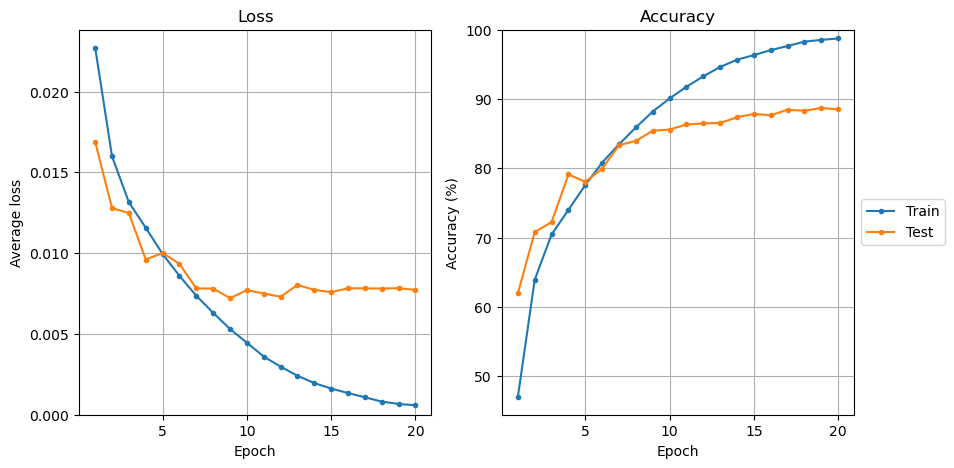

In [35]:
utils.plot_learning_curves(results, params_trainer['num_epochs'])

In [36]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, dataloader_args)['test'],
    model,
    criterion
)
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Incorrect Predictions 1149


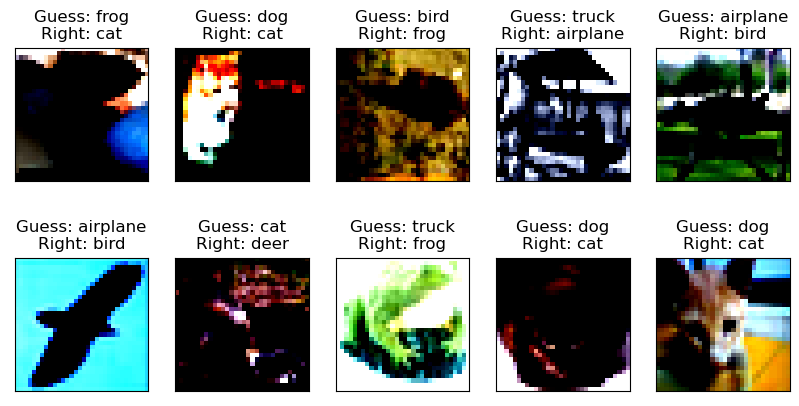

In [37]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)